автор тетрадки: Илья Гусев @YallenGusev

In [1]:
%%writefile requirements.txt
pytorch-lightning
scikit-learn
razdel
fasttext
transformers
ipdb
sentencepiece
gensim

Writing requirements.txt


In [ ]:
!pip install --upgrade -r requirements.txt

In [1]:
import ipdb
import os
import re
import random
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import razdel
from razdel import tokenize
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, RandomSampler
from torchmetrics.classification.accuracy import Accuracy

from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping  
from transformers import XLMRobertaTokenizer, XLMRobertaModel
from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

## Датасет

Классификация русскоязычных твиттов по тональности (pos vs neg)

http://study.mokoron.com/

https://habr.com/ru/company/mailru/blog/417767/

https://habr.com/ru/post/472988/

In [3]:
!rm negative.csv
!rm positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv

--2022-11-11 13:43:31--  https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/r6u59ljhhjdg6j0/negative.csv [following]
--2022-11-11 13:43:32--  https://www.dropbox.com/s/raw/r6u59ljhhjdg6j0/negative.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5eb0e431bb696a15cb67944b79.dl.dropboxusercontent.com/cd/0/inline/BwijeRBIB_Vu5s9mLfG2fvinbYGPYww3q5FJWB8dUlJAhyIXEOs1AHP6QIMBjtf8jkNro5fTTPlfEo3D755sTt2-BliR9PLL1xK045aGzxiAj_Dceq8G-lsBMf9ys9jfJwl2qy_yGov6Qe6PvJcnHPdzlf1XWBY-Arer9SurgUglSQ/file# [following]
--2022-11-11 13:43:32--  https://uc5eb0e431bb696a15cb67944b79.dl.dropboxusercontent.com/cd/0/inline/BwijeRBIB_Vu5s9mLfG2fvinbYGPYww3q5FJWB8dUlJAhyIXEOs1AHP6QIMBjtf8jkNro5fTTPlfE

In [4]:

n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
data_positive = pd.read_csv('positive.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])
data_negative = pd.read_csv('negative.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])

sample_size = min(data_positive.shape[0], data_negative.shape[0])
raw_data = np.concatenate((data_positive['text'].values[:sample_size], data_negative['text'].values[:sample_size]), axis=0)

def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

df_train = pd.DataFrame(columns=['text', 'label'])
df_val = pd.DataFrame(columns=['text', 'label'])
df_test = pd.DataFrame(columns=['text', 'label'])

data = [preprocess_text(t) for t in raw_data]
labels = [1] * sample_size + [0] * sample_size
df_train['text'], df_test['text'], df_train['label'], df_test['label'] = train_test_split(data, labels, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=1)
df_train

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,text,label
85913,раньше все встречались у фонтана в гуме а тепе...,1
42792,ни когда не пойму любовь женщины к женщине хот...,1
85556,два сеанса в кино вот что я люблю парам пам па...,1
36360,я нашел мой наряд для кэти перри USER URL via ...,1
154940,USER ууууу всеее развод обидки и все дела,1
...,...,...
73349,закидываю свой вконтакторостер строчками из пе...,1
109259,гребаный понедельник гребанные 4 пары хочу дом...,0
50057,болячки вроде подживают но губы увеличелись в ...,0
5192,USER я знала что она добрая а за что она тебе,1


In [5]:
train_labels = df_train["label"].tolist()
val_labels = df_val["label"].tolist()
test_labels = df_test["label"].tolist()

texts_set = set(df_train["text"].tolist()) | set(df_val["text"].tolist()) | set(df_test["text"].tolist())

train_texts = [[token.text for token in tokenize(text)] for text in df_train["text"].tolist()]
val_texts = [[token.text for token in tokenize(text)] for text in df_val["text"].tolist()]
test_texts = [[token.text for token in tokenize(text)] for text in df_test["text"].tolist()]

In [6]:

class Vocabulary:
    def __init__(self):
        self.word2index = {
            "<pad>": 0,
            "<unk>": 1
        }
        self.index2word = ["<pad>", "<unk>"]

    def build(self, texts, min_count=7):
        words_counter = Counter(token for tokens in texts for token in tokens)
        for word, count in words_counter.most_common():
            if count >= min_count:
                self.word2index[word] = len(self.word2index)
        self.index2word = [word for word, _ in sorted(self.word2index.items(), key=lambda x: x[1])]
    
    def get_pad(self):
        return self.word2index["<pad>"]

    def get_unk(self):
        return self.word2index["<unk>"]
    
    @property
    def size(self):
        return len(self.index2word)
    
    def top(self, n=100):
        return self.index2word[1:n+1]
   
    def get_index(self, word):
        return self.word2index.get(word, self.get_unk())
    
    def get_word(self, index):
        return self.index2word[index]

vocabulary = Vocabulary()
vocabulary.build(train_texts)
assert vocabulary.word2index[vocabulary.index2word[10]] == 10
print(vocabulary.size)
print(vocabulary.top(100))

17198
['<unk>', 'USER', 'не', 'я', 'и', 'в', 'на', 'rt', 'а', 'что', 'URL', 'с', 'как', 'у', 'все', 'меня', 'то', 'это', 'так', 'мне', 'd', 'но', 'ты', 'ну', 'по', 'за', 'еще', 'уже', 'вот', 'да', 'же', 'только', 'сегодня', 'о', 'бы', 'нет', 'когда', 'хочу', 'к', 'очень', 'тебя', 'из', 'он', '3', 'день', 'просто', 'мы', 'будет', '2', 'от', 'было', 'если', 'тебе', 'теперь', 'надо', 'даже', 'тоже', 'завтра', 'кто', 'до', 'там', 'его', '1', 'вообще', 'есть', 'для', 'она', 'сейчас', 'спасибо', 'нас', 'буду', 'почему', 'блин', 'могу', 'люблю', 'без', 'знаю', 'вы', 'они', 'тут', 'или', 'раз', 'мой', 'чем', 'ничего', 'со', 'больше', 'всегда', '5', 'хорошо', 'дома', 'про', 'всем', 'можно', 'ее', 'может', 'год', 'потом', 'был', 'спать']


In [7]:

class TextDataset(Dataset):
    def __init__(self, tokenized_texts, labels, vocabulary, max_seq_len=55):
        self.samples = []
        assert len(tokenized_texts) != 0
        assert len(tokenized_texts) == len(labels)
        for text, label in zip(tokenized_texts, labels):
            indices = [vocabulary.get_index(word) for word in text][:max_seq_len]
            indices += [vocabulary.get_pad() for _ in range(max_seq_len - len(indices))]
            self.samples.append((torch.LongTensor(indices), torch.LongTensor([label])))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        return self.samples[index]


BATCH_SIZE = 128

train_data = TextDataset(train_texts, train_labels, vocabulary)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)

val_data = TextDataset(val_texts, val_labels, vocabulary)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

test_data = TextDataset(test_texts, test_labels, vocabulary)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [8]:
class SimpleModel(LightningModule):
    def __init__(self):
        super().__init__()
        
        self.loss = nn.BCEWithLogitsLoss()
        self.valid_accuracy = Accuracy()
        self.test_accuracy = Accuracy()
    
    def forward(self, inputs, labels):
        raise NotImplementedError("forward not implemented")
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
        return [optimizer]
    
    def training_step(self, batch, _):
        inputs, labels = batch
        loss, logits = self(inputs, labels)
        return loss
    
    def validation_step(self, batch, _):
        inputs, labels = batch
        val_loss, logits = self(inputs, labels)
        self.valid_accuracy.update(logits, labels)
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", self.valid_accuracy)

    def validation_epoch_end(self, outs):
        self.log("val_acc_epoch", self.valid_accuracy.compute(), prog_bar=True)

    def test_step(self, batch, _):
        inputs, labels = batch
        test_loss, logits = self(inputs, labels)
        self.test_accuracy.update(logits, labels)
        self.log("test_loss", test_loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy)

    def test_epoch_end(self, outs):
        self.log("test_acc_epoch", self.test_accuracy.compute(), prog_bar=True)

## Полносвязная сеть



In [9]:
import torch
import torch.nn as nn
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping  

class FFModel(SimpleModel):
    def __init__(self, vocab_size, embedding_dim=32, hidden_dim=64):
        super().__init__()
        self.embeddings_layer = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_layer = nn.Linear(embedding_dim, hidden_dim)
        self.relu_layer = nn.ReLU()
        self.dropout_layer = nn.Dropout(0.2)
        self.out_layer = nn.Linear(hidden_dim, 1)
    
    def forward(self, inputs, labels):
        # batch_size x seq_len
        projections = self.embeddings_layer(inputs)
        # batch_size x seq_len x embedding_dim
        projections = self.dropout_layer(self.relu_layer(self.hidden_layer(projections)))
        # batch_size x seq_len x hidden_dim
        pooling = torch.max(projections, 1)[0]
        # batch_size x hidden_dim
        logits = self.out_layer(pooling)
        loss = self.loss(logits, labels.float())
        return loss, logits

In [ ]:
ff_model = FFModel(vocabulary.size)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=1,
    verbose=True,
    mode="min" 
)
trainer = Trainer(
    gpus=1,
    #checkpoint_callback=False,
    accumulate_grad_batches=1,
    max_epochs=10,
    #progress_bar_refresh_rate=10,
    callbacks=[early_stop_callback])
trainer.fit(ff_model, train_loader, val_loader)
trainer.test(ff_model, test_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type              | Params
-------------------------------------------------------
0 | loss             | BCEWithLogitsLoss | 0     
1 | valid_accuracy   | Accuracy      

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.543


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.512


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.492


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.482


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.481


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.475


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 0.475. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7547687888145447
     test_acc_epoch         0.7547687888145447
        test_loss           0.48078301548957825
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.48078301548957825,
  'test_acc': 0.7547687888145447,
  'test_acc_epoch': 0.7547687888145447}]

## Свёрточная сеть
![Conv example](https://image.ibb.co/e6t8ZK/Convolution.gif)

*From [Feature extraction using convolution](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution).*
NLP conv example

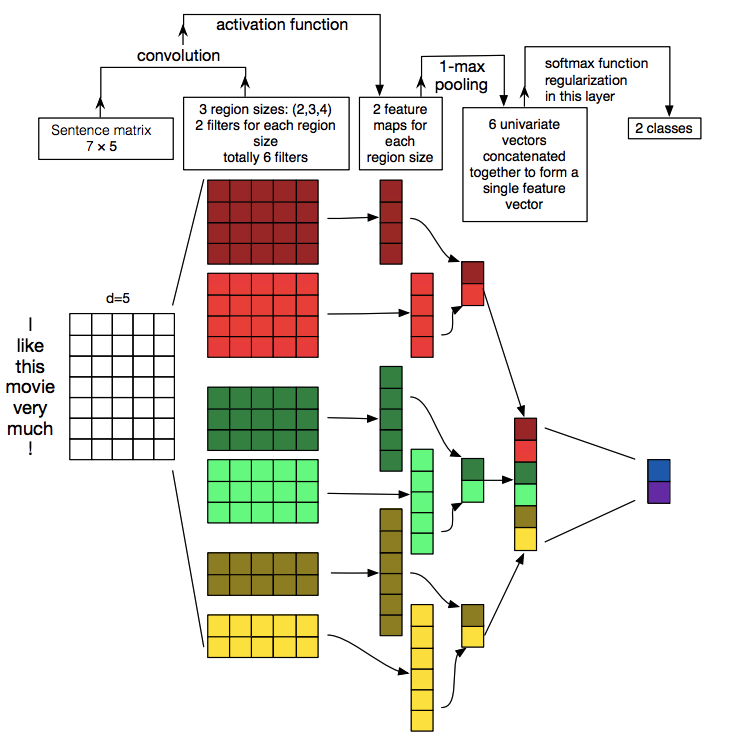

*From [(Text-Classification-Pytorch)](https://github.com/dongjun-Lee/text-classification-models-tf)*

* https://debajyotidatta.github.io/nlp/deep/learning/word-embeddings/2016/11/27/Understanding-Convolutions-In-Text/


In [ ]:

class CnnModel(SimpleModel):
    def __init__(self, vocab_size, embedding_dim=128, filters=((2, 10), (3, 8))):
        super().__init__()
        self.embeddings_layer = nn.Embedding(vocab_size, embedding_dim)
        self.filters = []
        all_filters_count = 0
        for kernel_size, filters_count in filters:
            all_filters_count += filters_count
            self.filters.append(nn.Conv2d(1, filters_count, (kernel_size, embedding_dim), padding='valid'))
        self.filters = nn.ModuleList(self.filters)
        self.relu_layer = nn.ReLU()
        self.dropout_layer = nn.Dropout(0.2)
        self.out_layer = nn.Linear(all_filters_count, 1)
    
    def forward(self, inputs, labels):
        projections = self.embeddings_layer(inputs)
        # batch_size x seq_len x embedding_dim
        projections = projections.unsqueeze(1)
        # batch_size x 1 x seq_len x embedding_dim
        results = []
        for f in self.filters:
          convolved = self.dropout_layer(self.relu_layer(f(projections)))
          convolved = convolved.squeeze(3)
          # batch_size x num_filters x seq_len*
          pooling = torch.max(convolved, 2)[0]
          # batch_size x num_filters
          results.append(pooling)
        output = torch.cat(results, 1)
        # batch_size x sum(num_filters)
        # 128 x 18
        logits = self.out_layer(output)
        loss = self.loss(logits, labels.float())
        return loss, logits

cnn_model = CnnModel(vocabulary.size)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=1,
    verbose=True,
    mode="min" 
)
trainer = Trainer(
    gpus=1,
    #checkpoint_callback=False,
    accumulate_grad_batches=1,
    max_epochs=10,
    #progress_bar_refresh_rate=10,
    callbacks=[early_stop_callback])
trainer.fit(cnn_model, train_loader, val_loader)
trainer.test(cnn_model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type              | Params
-------------------------------------------------------
0 | loss             | BCEWithLogitsLoss | 0     
1 | valid_accuracy   | Accuracy          | 0     
2 | test_accuracy    | Accuracy          | 0     
3 | embeddings_layer | Embedding         | 2.2 M 
4 | filters          | ModuleList        | 5.7 K 
5 | relu_layer       | ReLU              | 0     
6 | dropout_layer    | Dropout           | 0     
7 | out_layer        | Linear            | 19    
---------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.515


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.484


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.469


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.466


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.465


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 0.465. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7622514963150024
     test_acc_epoch         0.7622514963150024
        test_loss           0.4775075316429138
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.4775075316429138,
  'test_acc': 0.7622514963150024,
  'test_acc_epoch': 0.7622514963150024}]

## Рекуррентные сети

![rnn](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)  
*From [(Understanding LSTM Networks)](http://colah.github.io/posts/2015-08-Understanding-LSTMs)*

In [ ]:
class RnnModel(SimpleModel):
    def __init__(self, vocab_size, embedding_dim=128):
        super().__init__()
        self.embeddings_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(embedding_dim, embedding_dim, batch_first=True, bidirectional=True)
        self.dropout_layer = nn.Dropout(0.2)
        self.out_layer = nn.Linear(2 * embedding_dim, 1)
    
    def forward(self, inputs, labels):
        batch_size = inputs.size(0)
        projections = self.embeddings_layer(inputs)
        # batch_size x seq_len x embedding_dim
        output, (final_hidden_state, final_cell_state) = self.lstm_layer(projections)
        # 2 x batch_size x embedding_dim
        final_hidden_state = final_hidden_state.transpose(0, 1)
        # batch_size x 2 x embedding_dim
        final_hidden_state = final_hidden_state.reshape(batch_size, -1)
        # batch_size x 2*embedding_dim
        hidden = self.dropout_layer(final_hidden_state)
        logits = self.out_layer(hidden)
        loss = self.loss(logits, labels.float())
        return loss, logits

rnn_model = RnnModel(vocabulary.size)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=1,
    verbose=True,
    mode="min" 
)
trainer = Trainer(
    gpus=1,
    #checkpoint_callback=False,
    accumulate_grad_batches=1,
    max_epochs=10,
    #progress_bar_refresh_rate=10,
    callbacks=[early_stop_callback])
trainer.fit(rnn_model, train_loader, val_loader)
trainer.test(rnn_model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type              | Params
-------------------------------------------------------
0 | loss             | BCEWithLogitsLoss | 0     
1 | valid_accuracy   | Accuracy          | 0     
2 | test_accuracy    | Accuracy          | 0     
3 | embeddings_layer | Embedding         | 2.2 M 
4 | lstm_layer       | LSTM              | 264 K 
5 | dropout_layer    | Dropout           | 0     
6 | out_layer        | Linear            | 257   
-------------------------------------------------------
2.5 M     Trainable params
0     

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.482


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.462


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.452


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 0.452. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7722805738449097
     test_acc_epoch         0.7722805738449097
        test_loss           0.4730708599090576
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.4730708599090576,
  'test_acc': 0.7722805738449097,
  'test_acc_epoch': 0.7722805738449097}]

## Задание 1
Сделайте char-level CNN для решения этой же задачи  -- *2 балла*

Попробуйте подобрать архитектуру и гиперпараметры (embedding_dim, количество и размер фильтров, lr) так, чтобы результат улучшился -- *1 балл*

In [ ]:
class CharacterLevelCNN(SimpleModel):
    def __init__(self, vocab_size, embedding_dim=256, n_classes=1, n_conv_filters=128,
                 n_fc_neurons=1024):
        super().__init__()

        self.embeddings_layer = nn.Embedding(vocab_size, embedding_dim)

        self.conv1 = nn.Sequential(nn.Conv1d(55, n_conv_filters, kernel_size=7, padding=0), nn.ReLU(),
                                   nn.MaxPool1d(3))
        self.conv2 = nn.Sequential(nn.Conv1d(n_conv_filters, n_conv_filters, kernel_size=7, padding=0), nn.ReLU(),
                                   nn.MaxPool1d(3))
        self.conv3 = nn.Sequential(nn.Conv1d(n_conv_filters, n_conv_filters, kernel_size=3, padding=0), nn.ReLU())
        #self.conv4 = nn.Sequential(nn.Conv1d(n_conv_filters, n_conv_filters, kernel_size=3, padding=0), nn.ReLU())
        #self.conv5 = nn.Sequential(nn.Conv1d(n_conv_filters, n_conv_filters, kernel_size=3, padding=0), nn.ReLU())
        self.conv6 = nn.Sequential(nn.Conv1d(n_conv_filters, n_conv_filters, kernel_size=3, padding=0), nn.ReLU(),
                                   nn.MaxPool1d(3))
        
        self.fc1 = nn.Sequential(nn.Linear(3328, n_fc_neurons), nn.ReLU(), nn.Dropout(0.2))
        #self.fc2 = nn.Sequential(nn.Linear(n_fc_neurons, n_fc_neurons), nn.Dropout(0.5))
        self.fc3 = nn.Linear(n_fc_neurons, n_classes)

    def forward(self, input, labels):
        input = self.embeddings_layer(input)
        output = self.conv1(input)
        #output = self.conv2(output)
        output = self.conv3(output)
        #output = self.conv4(output)
        #output = self.conv5(output)
        output = self.conv6(output)

        output = output.view(output.size(0), -1)
        output = self.fc1(output)
        #output = self.fc2(output)
        output = self.fc3(output)

        loss = self.loss(output, labels.float())
        return loss, output

cnn_model = CharacterLevelCNN(vocabulary.size)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=1,
    verbose=True,
    mode="min" 
)
trainer = Trainer(
    gpus=1,
    #checkpoint_callback=False,
    accumulate_grad_batches=1,
    max_epochs=10,
    #progress_bar_refresh_rate=10,
    callbacks=[early_stop_callback])
trainer.fit(cnn_model, train_loader, val_loader)
trainer.test(cnn_model, test_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type              | Params
-------------------------------------------------------
0 | loss             | BCEWithLogitsLoss | 0     
1 | valid_accuracy   | Accuracy      

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.494


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.464


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 0.464. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7639267444610596
     test_acc_epoch         0.7639267444610596
        test_loss           0.47434285283088684
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.47434285283088684,
  'test_acc': 0.7639267444610596,
  'test_acc_epoch': 0.7639267444610596}]

In [ ]:

class CnnModel(SimpleModel):
    def __init__(self, vocab_size, embedding_dim=256, filters=((2, 10), (3, 8), (4,6))):
        super().__init__()
        self.embeddings_layer = nn.Embedding(vocab_size, embedding_dim)
        self.filters = []
        all_filters_count = 0
        for kernel_size, filters_count in filters:
            all_filters_count += filters_count
            self.filters.append(nn.Conv2d(1, filters_count, (kernel_size, embedding_dim), padding='valid'))
        self.filters = nn.ModuleList(self.filters)
        self.relu_layer = nn.ReLU()
        self.dropout_layer = nn.Dropout(0.2)
        self.out_layer = nn.Linear(all_filters_count, 1)
    
    def forward(self, inputs, labels):
        projections = self.embeddings_layer(inputs)
        # batch_size x seq_len x embedding_dim
        projections = projections.unsqueeze(1)
        # batch_size x 1 x seq_len x embedding_dim
        results = []
        for f in self.filters:
          convolved = self.dropout_layer(self.relu_layer(f(projections)))
          convolved = convolved.squeeze(3)
          # batch_size x num_filters x seq_len*
          pooling = torch.max(convolved, 2)[0]
          # batch_size x num_filters
          results.append(pooling)
        output = torch.cat(results, 1)
        # batch_size x sum(num_filters)
        # 128 x 18
        logits = self.out_layer(output)
        loss = self.loss(logits, labels.float())
        return loss, logits

cnn_model = CnnModel(vocabulary.size)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=1,
    verbose=True,
    mode="min" 
)
trainer = Trainer(
    gpus=1,
    #checkpoint_callback=False,
    accumulate_grad_batches=1,
    max_epochs=10,
    #progress_bar_refresh_rate=10,
    callbacks=[early_stop_callback])
trainer.fit(cnn_model, train_loader, val_loader)
trainer.test(cnn_model, test_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type              | Params
-------------------------------------------------------
0 | loss             | BCEWithLogitsLoss | 0     
1 | valid_accuracy   | Accuracy      

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.504


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.475


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.467


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.463


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 0.463. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7680366039276123
     test_acc_epoch         0.7680366039276123
        test_loss           0.4719146490097046
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.4719146490097046,
  'test_acc': 0.7680366039276123,
  'test_acc_epoch': 0.7680366039276123}]

## Использование предобученных эмбеддингов

In [ ]:
import gensim

In [ ]:
gensim.__version__

'4.2.0'

In [ ]:
!wget https://www.dropbox.com/s/9egqjszeicki4ho/db.sql

--2022-11-09 20:16:56--  https://www.dropbox.com/s/9egqjszeicki4ho/db.sql
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/9egqjszeicki4ho/db.sql [following]
--2022-11-09 20:16:56--  https://www.dropbox.com/s/raw/9egqjszeicki4ho/db.sql
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc614738d43ab4a82e76e3adc16c.dl.dropboxusercontent.com/cd/0/inline/Bwed7x4TwGDkkYfsNiiPLBqiY9-Jk5gsYOCcr_BeHQbJdv0OXnoX3Sunz2gQ6WdwejEgXUG8b82YOEQMKBFJe4gDCwwusEYcHKObJQWR90AB_YQpLIEE6ekIOfwzRYeWycOqjWOSDnEdWeMpdnzIPaJmBkCCzDhDh46BYtHACocCwA/file# [following]
--2022-11-09 20:16:57--  https://uc614738d43ab4a82e76e3adc16c.dl.dropboxusercontent.com/cd/0/inline/Bwed7x4TwGDkkYfsNiiPLBqiY9-Jk5gsYOCcr_BeHQbJdv0OXnoX3Sunz2gQ6WdwejEgXUG8b82YOEQMKBFJe4gDCwwusEYcHK

In [ ]:
!head -n 50 db.sql

-- MySQL dump 10.13  Distrib 5.6.12, for osx10.6 (x86_64)
--
-- Host: localhost    Database: neu
-- ------------------------------------------------------
-- Server version	5.6.12

/*!40101 SET @OLD_CHARACTER_SET_CLIENT=@@CHARACTER_SET_CLIENT */;
/*!40101 SET @OLD_CHARACTER_SET_RESULTS=@@CHARACTER_SET_RESULTS */;
/*!40101 SET @OLD_COLLATION_CONNECTION=@@COLLATION_CONNECTION */;
/*!40101 SET NAMES utf8 */;
/*!40103 SET @OLD_TIME_ZONE=@@TIME_ZONE */;
/*!40103 SET TIME_ZONE='+00:00' */;
/*!40014 SET @OLD_UNIQUE_CHECKS=@@UNIQUE_CHECKS, UNIQUE_CHECKS=0 */;
/*!40014 SET @OLD_FOREIGN_KEY_CHECKS=@@FOREIGN_KEY_CHECKS, FOREIGN_KEY_CHECKS=0 */;
/*!40101 SET @OLD_SQL_MODE=@@SQL_MODE, SQL_MODE='NO_AUTO_VALUE_ON_ZERO' */;
/*!40111 SET @OLD_SQL_NOTES=@@SQL_NOTES, SQL_NOTES=0 */;

--
-- Table structure for table `sentiment`
--

DROP TABLE IF EXISTS `sentiment`;
/*!40101 SET @saved_cs_client     = @@character_set_client */;
/*!40101 SET character_set_client = utf8 */;
CREATE TABLE `sentiment` (
  `id` 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

In [ ]:
%%time
with open('ft_text.txt', 'w') as out:
  count = 0
  skipped = 0
  with open("db.sql") as r:
      for line in r:
          records = line.replace("INSERT INTO `sentiment` VALUES", "").split("),(")
          if len(records) == 1:
              continue
          for record in records:
              text = record.split(",")[3][1:-1]
              text = preprocess_text(text)
              if text in texts_set:
                skipped += 1
              else:
                count += 1
                out.write(f'{text}\n')
print(count, skipped)


17478290 161386
CPU times: user 4min 44s, sys: 7.68 s, total: 4min 52s
Wall time: 4min 54s


In [ ]:
%%time
ft = gensim.models.FastText(corpus_file='ft_text.txt')

In [ ]:
fname = 'ru_tweets_ft.model'
ft.save(fname)

In [ ]:
ft = gensim.models.FastText.load(fname)

In [ ]:
ft.wv.most_similar('слово')

In [ ]:
weights = np.zeros((vocabulary.size, 100))
count = 0
for word, i in vocabulary.word2index.items():
    if word == '<pad>':
        continue   
    try:
        weights[i] = ft.wv[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,100)

In [ ]:
weights

In [ ]:
class RnnFTModel(SimpleModel):
    def __init__(self, vocab_size, weights, embedding_dim=128):
        super().__init__()
        self.embeddings_layer = nn.Embedding(vocab_size, embedding_dim)
        self.embeddings_layer.from_pretrained(torch.tensor(weights), freeze=True)
        self.lstm_layer = nn.LSTM(embedding_dim, embedding_dim, batch_first=True, bidirectional=True)
        self.dropout_layer = nn.Dropout(0.2)
        self.out_layer = nn.Linear(2 * embedding_dim, 1)
    
    def forward(self, inputs, labels):
        batch_size = inputs.size(0)
        projections = self.embeddings_layer(inputs)
        output, (final_hidden_state, final_cell_state) = self.lstm_layer(projections)
        # 2 x batch_size x embedding_dim
        final_hidden_state = final_hidden_state.transpose(0, 1)
        # batch_size x 2 x embedding_dim
        final_hidden_state = final_hidden_state.reshape(batch_size, -1)
        # batch_size x 2*embedding_dim
        hidden = self.dropout_layer(final_hidden_state)
        logits = self.out_layer(hidden)
        loss = self.loss(logits, labels.float())
        return loss, logits

rnn_model = RnnFTModel(vocabulary.size, weights, embedding_dim=100)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=1,
    verbose=True,
    mode="min" 
)
trainer = Trainer(
    gpus=0,
    #checkpoint_callback=False,
    accumulate_grad_batches=1,
    max_epochs=10,
    #progress_bar_refresh_rate=10,
    callbacks=[early_stop_callback])
trainer.fit(rnn_model, train_loader, val_loader)
trainer.test(rnn_model, test_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1767: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type      

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.480


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.456


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.448


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 0.448. Signaling Trainer to stop.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7650435566902161
     test_acc_epoch         0.7650435566902161
        test_loss           0.47039544582366943
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.47039544582366943,
  'test_acc': 0.7650435566902161,
  'test_acc_epoch': 0.7650435566902161}]

## Задание 2
Сделайте RNN с другими готовыми эмбеддингами (не обязательно fastText) для решения этой же задачи *1 балл*

In [ ]:
!wget http://vectors.nlpl.eu/repository/20/213.zip
!unzip 213.zip -d geowac_lemmas_none_fasttextskipgram_300_5_2020

--2022-11-09 20:15:08--  http://vectors.nlpl.eu/repository/20/213.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1485270300 (1.4G) [application/zip]
Saving to: ‘213.zip’

213.zip             100%[===================>]   1.38G  22.6MB/s    in 63s     

2022-11-09 20:16:12 (22.4 MB/s) - ‘213.zip’ saved [1485270300/1485270300]

Archive:  213.zip
  inflating: geowac_lemmas_none_fasttextskipgram_300_5_2020/meta.json  
  inflating: geowac_lemmas_none_fasttextskipgram_300_5_2020/model.model  
  inflating: geowac_lemmas_none_fasttextskipgram_300_5_2020/model.model.vectors_ngrams.npy  
  inflating: geowac_lemmas_none_fasttextskipgram_300_5_2020/model.model.vectors.npy  
  inflating: geowac_lemmas_none_fasttextskipgram_300_5_2020/model.model.vectors_vocab.npy  
  inflating: geowac_lemmas_none_fasttextskipgram_300_5_2020/README  


In [ ]:
path = "geowac_lemmas_none_fasttextskipgram_300_5_2020/model.model"
ft = gensim.models.keyedvectors.FastTextKeyedVectors.load(path)

In [ ]:
ft.most_similar('слово')

[('фраза', 0.6476999521255493),
 ('словатраница', 0.633973240852356),
 ('словосочетание', 0.631287157535553),
 ('словамтраница', 0.6128177046775818),
 ('словечко', 0.6116117835044861),
 ('словтраница', 0.6109633445739746),
 ('произносить', 0.6010148525238037),
 ('произнесять', 0.5910414457321167),
 ('словом', 0.5892109870910645),
 ('произнесать', 0.5823625922203064)]

In [ ]:
weights = np.zeros((vocabulary.size, 300))
count = 0
for word, i in vocabulary.word2index.items():
    if word == '<pad>':
        continue   
    try:
        weights[i] = ft[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,300)

In [ ]:
weights

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05999708,  0.13498203, -0.1392251 , ...,  0.23445298,
         0.03143148,  0.07356777],
       [-0.04286176, -0.0345582 , -0.0145607 , ..., -0.06147824,
         0.02219105, -0.01256019],
       ...,
       [ 0.14264753, -0.33729386, -0.25059864, ..., -0.44172853,
         0.04544379,  0.31718349],
       [-0.16277348,  0.40683758, -0.21673881, ..., -0.18738431,
        -0.40520221, -0.65514243],
       [ 0.09010279,  0.45301834,  0.00187415, ...,  0.19487594,
         0.54743046,  0.17115487]])

In [ ]:
print(weights.shape)

(17198, 300)


In [ ]:
class RnnFTModel(SimpleModel):
    def __init__(self, vocab_size, weights, embedding_dim=128):
        super().__init__()
        self.embeddings_layer = nn.Embedding(vocab_size, embedding_dim)
        self.embeddings_layer.from_pretrained(torch.tensor(weights), freeze=True)
        self.lstm_layer = nn.LSTM(embedding_dim, embedding_dim, batch_first=True, bidirectional=True)
        self.dropout_layer = nn.Dropout(0.2)
        self.out_layer = nn.Linear(2 * embedding_dim, 1)
    
    def forward(self, inputs, labels):
        batch_size = inputs.size(0)
        projections = self.embeddings_layer(inputs)
        output, (final_hidden_state, final_cell_state) = self.lstm_layer(projections)
        # 2 x batch_size x embedding_dim
        final_hidden_state = final_hidden_state.transpose(0, 1)
        # batch_size x 2 x embedding_dim
        final_hidden_state = final_hidden_state.reshape(batch_size, -1)
        # batch_size x 2*embedding_dim
        hidden = self.dropout_layer(final_hidden_state)
        logits = self.out_layer(hidden)
        loss = self.loss(logits, labels.float())
        return loss, logits

rnn_model = RnnFTModel(vocabulary.size, weights, embedding_dim=300)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=1,
    verbose=True,
    mode="min" 
)
trainer = Trainer(
    gpus=0,
    #checkpoint_callback=False,
    accumulate_grad_batches=1,
    max_epochs=10,
    #progress_bar_refresh_rate=10,
    callbacks=[early_stop_callback])
trainer.fit(rnn_model, train_loader, val_loader)
trainer.test(rnn_model, test_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/setup.py:178: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type         

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.465


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.453


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 0.453. Signaling Trainer to stop.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7723028659820557
     test_acc_epoch         0.7723028659820557
        test_loss           0.46094998717308044
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.46094998717308044,
  'test_acc': 0.7723028659820557,
  'test_acc_epoch': 0.7723028659820557}]

## XLMRoBERTa: SOTA трансформеры

In [ ]:
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
sentence = "Давайте попробуем что-нибудь потокенизировать"
tokenizer(sentence,
        add_special_tokens=True,
        max_length=256,
        padding="max_length",
        truncation=True)

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

{'input_ids': [0, 169023, 129, 60958, 121900, 414, 9, 23257, 57661, 812, 161084, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
class XLMRDataset(Dataset):
    def __init__(self, texts, labels, max_tokens=256):
        self.texts = [" ".join(tokens) for tokens in texts]
        self.labels = labels
        self.tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
        self.max_tokens = max_tokens
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        sentence = self.texts[index]
        inputs = self.tokenizer(sentence,
                                add_special_tokens=True,
                                max_length=self.max_tokens,
                                padding="max_length",
                                truncation=True)
        return torch.tensor(inputs["input_ids"]), torch.tensor(inputs["attention_mask"]), self.labels[index]


MAX_TOKENS = 100
BATCH_SIZE = 32
EPOCHS = 4

xlm_train_data = XLMRDataset(train_texts, train_labels, MAX_TOKENS)
xlm_train_sampler = RandomSampler(xlm_train_data)
xlm_train_loader = DataLoader(xlm_train_data, batch_size=BATCH_SIZE, sampler=xlm_train_sampler)

xlm_val_data = XLMRDataset(val_texts, val_labels, MAX_TOKENS)
xlm_val_loader = DataLoader(xlm_val_data, batch_size=BATCH_SIZE)

xlm_test_data = XLMRDataset(test_texts, test_labels, MAX_TOKENS)
xlm_test_loader = DataLoader(xlm_test_data, batch_size=BATCH_SIZE)

TOTAL_STEPS = (len(xlm_train_data) // BATCH_SIZE + 1) * EPOCHS

In [ ]:
ids, attns, labels = next(iter(xlm_train_loader))

In [ ]:
xlm = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [ ]:
xlm(ids, attns, labels=labels, return_dict=False)

(tensor(0.6869, grad_fn=<NllLossBackward0>), tensor([[-0.0847, -0.1500],
         [-0.0962, -0.1343],
         [-0.0897, -0.1273],
         [-0.0819, -0.1459],
         [-0.0780, -0.1441],
         [-0.0855, -0.1348],
         [-0.0895, -0.1398],
         [-0.0842, -0.1315],
         [-0.0816, -0.1360],
         [-0.0765, -0.1318],
         [-0.0922, -0.1450],
         [-0.0928, -0.1426],
         [-0.0864, -0.1399],
         [-0.0814, -0.1423],
         [-0.0862, -0.1386],
         [-0.0777, -0.1319],
         [-0.0837, -0.1271],
         [-0.0778, -0.1346],
         [-0.0860, -0.1441],
         [-0.0823, -0.1446],
         [-0.0804, -0.1278],
         [-0.0727, -0.1276],
         [-0.0846, -0.1406],
         [-0.0790, -0.1581],
         [-0.0818, -0.1434],
         [-0.0831, -0.1375],
         [-0.0816, -0.1387],
         [-0.0814, -0.1267],
         [-0.0889, -0.1495],
         [-0.0872, -0.1419],
         [-0.0879, -0.1450],
         [-0.0867, -0.1271]], grad_fn=<AddmmBackward0>))

In [ ]:
class XLMRClassifier(LightningModule):
    def __init__(self, num_classes=2, model_path="xlm-roberta-base"):
        super(XLMRClassifier, self).__init__()
        self.model = XLMRobertaForSequenceClassification.from_pretrained(model_path, num_labels=num_classes)
        self.save_hyperparameters() 
        self.valid_accuracy = Accuracy()
        self.test_accuracy = Accuracy()

    def forward(self, input_ids, attention_mask, labels):
        return self.model(input_ids, attention_mask, labels=labels, return_dict=False)

    def training_step(self, batch, _):
        inputs, attn, labels = batch
        loss, logits = self(inputs, attn, labels)
        return loss
    
    def validation_step(self, batch, _):
        inputs, attn, labels = batch
        val_loss, logits = self(inputs, attn, labels)
        self.valid_accuracy.update(logits, labels)
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", self.valid_accuracy)

    def validation_epoch_end(self, outs):
        self.log("val_acc_epoch", self.valid_accuracy.compute(), prog_bar=True)

    def test_step(self, batch, _):
        inputs, attn, labels = batch
        test_loss, logits = self(inputs, attn, labels)
        self.test_accuracy.update(logits, labels)
        self.log("test_loss", test_loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy)

    def test_epoch_end(self, outs):
        self.log("test_acc_epoch", self.test_accuracy.compute(), prog_bar=True)

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=1e-5)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=TOTAL_STEPS)
        return [optimizer], [scheduler]



In [ ]:
clf = XLMRClassifier()
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=1,
    verbose=True,
    mode="min" 
)
trainer = Trainer(
    gpus=1,
    #checkpoint_callback=False,
    accumulate_grad_batches=6,
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback],
    val_check_interval=0.5)
trainer.fit(clf, xlm_train_loader, xlm_val_loader)
trainer.test(clf, xlm_test_loader)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

## Задание 3

Обучить тяжелую языковую модель на нашей задаче (
 multilingual BERT, ruBERT), получив качество выше 80%. *2 балла*

Разметить обученной моделью данные из db.sql *2 балла*

На размеченных данных запустить легкую модель (CNN, RNN, charCNN, или комбинацию) *2 балла*

Домашку скидывать до 15 ноября на : 
komleva.ep@phystech.edu
@komleva1999

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification
#from transformers import ruBert

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
sentence = "Давайте попробуем что-нибудь потокенизировать"
tokenizer(sentence,
        add_special_tokens=True,
        max_length=256,
        padding="max_length",
        truncation=True)

{'input_ids': [101, 54294, 12921, 41592, 15491, 19647, 12690, 10887, 118, 19185, 86383, 10291, 22162, 15609, 15759, 32471, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [12]:
class BertDataset(Dataset):
    def __init__(self, texts, labels, max_tokens=256):
        self.texts = [" ".join(tokens) for tokens in texts]
        self.labels = labels
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
        self.max_tokens = max_tokens
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        sentence = self.texts[index]
        inputs = self.tokenizer(sentence,
                                add_special_tokens=True,
                                max_length=self.max_tokens,
                                padding="max_length",
                                truncation=True)
        return torch.tensor(inputs["input_ids"]), torch.tensor(inputs["attention_mask"]), self.labels[index]


MAX_TOKENS = 100
BATCH_SIZE = 32
EPOCHS = 4

bert_train_data = BertDataset(train_texts, train_labels, MAX_TOKENS)
bert_train_sampler = RandomSampler(bert_train_data)
bert_train_loader = DataLoader(bert_train_data, batch_size=BATCH_SIZE, sampler=bert_train_sampler)

bert_val_data = BertDataset(val_texts, val_labels, MAX_TOKENS)
bert_val_loader = DataLoader(bert_val_data, batch_size=BATCH_SIZE)

bert_test_data = BertDataset(test_texts, test_labels, MAX_TOKENS)
bert_test_loader = DataLoader(bert_test_data, batch_size=BATCH_SIZE)

TOTAL_STEPS = (len(bert_train_data) // BATCH_SIZE + 1) * EPOCHS

In [13]:
class BertClassifier(LightningModule):
    def __init__(self, num_classes=2, model_path='bert-base-multilingual-uncased'):
        super(BertClassifier, self).__init__()
        self.model = BertForSequenceClassification.from_pretrained(model_path, num_labels=num_classes)
        self.save_hyperparameters() 
        self.valid_accuracy = Accuracy()
        self.test_accuracy = Accuracy()

    def forward(self, input_ids, attention_mask, labels):
        return self.model(input_ids, attention_mask, labels=labels, return_dict=False)

    def training_step(self, batch, _):
        inputs, attn, labels = batch
        loss, logits = self(inputs, attn, labels)
        return loss
    
    def validation_step(self, batch, _):
        inputs, attn, labels = batch
        val_loss, logits = self(inputs, attn, labels)
        self.valid_accuracy.update(logits, labels)
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", self.valid_accuracy)

    def validation_epoch_end(self, outs):
        self.log("val_acc_epoch", self.valid_accuracy.compute(), prog_bar=True)

    def test_step(self, batch, _):
        inputs, attn, labels = batch
        test_loss, logits = self(inputs, attn, labels)
        self.test_accuracy.update(logits, labels)
        self.log("test_loss", test_loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy)

    def test_epoch_end(self, outs):
        self.log("test_acc_epoch", self.test_accuracy.compute(), prog_bar=True)

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=1e-5)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=TOTAL_STEPS)
        return [optimizer], [scheduler]



In [ ]:
clf = BertClassifier()
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=1,
    verbose=True,
    mode="min" 
)
trainer = Trainer(
    accelerator='gpu',
    gpus=1,
    #checkpoint_callback=False,
    accumulate_grad_batches=6,
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback],
    val_check_interval=0.5)
trainer.fit(clf, bert_train_loader, bert_val_loader)
trainer.test(clf, bert_test_loader)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
clf.model.to('cuda')

In [ ]:
from tqdm import tqdm

bert_train_labels = []
bert_val_labels = []
bert_test_labels = []

with torch.no_grad():
  for batch in bert_train_loader:
    inputs, attn, labels = batch

    inputs = inputs.to('cuda')
    attn = attn.to('cuda')
    labels = labels.to('cuda')

    _, logits = clf(inputs, attn, labels)
    _, idx = torch.max(torch.nn.functional.softmax(logits), dim=1)
    
    bert_train_labels = np.concatenate((bert_train_labels, idx.cpu().numpy()))

  for batch in tqdm(bert_val_loader):
    inputs, attn, labels = batch

    inputs = inputs.to('cuda')
    attn = attn.to('cuda')
    labels = labels.to('cuda')
    
    _, logits = clf(inputs, attn, labels)
    _, idx = torch.max(torch.nn.functional.softmax(logits), dim=1)
    bert_val_labels = np.concatenate((bert_val_labels, idx.cpu().numpy()))

  for batch in tqdm(bert_test_loader):
    inputs, attn, labels = batch

    inputs = inputs.to('cuda')
    attn = attn.to('cuda')
    labels = labels.to('cuda')

    _, logits = clf(inputs, attn, labels)
    _, idx = torch.max(torch.nn.functional.softmax(logits), dim=1)
    bert_test_labels = np.concatenate((bert_test_labels, idx.cpu().numpy()))

In [ ]:

class NewTextDataset(Dataset):
    def __init__(self, tokenized_texts, labels, bert_preds, vocabulary, max_seq_len=55):
        self.samples = []
        assert len(tokenized_texts) != 0
        assert len(tokenized_texts) == len(labels)
        for text, label, pred in zip(tokenized_texts, labels, bert_preds):
            indices = [vocabulary.get_index(word) for word in text][:max_seq_len]
            indices += [vocabulary.get_pad() for _ in range(max_seq_len - len(indices))]

            pred = int(pred > 0.5)
            self.samples.append(((torch.LongTensor(indices), torch.LongTensor([pred])), torch.LongTensor([label])))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        return self.samples[index]


BATCH_SIZE = 128

bert_train_labels = np.zeros(len(train_labels))
bert_val_labels = np.zeros(len(train_labels))
bert_test_labels = np.zeros(len(train_labels))

train_data = NewTextDataset(train_texts, train_labels, bert_train_labels, vocabulary)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)

val_data = NewTextDataset(val_texts, val_labels, bert_val_labels, vocabulary)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

test_data = NewTextDataset(test_texts, test_labels, bert_test_labels, vocabulary)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
class RnnFTModel(SimpleModel):
    def __init__(self, vocab_size, weights, embedding_dim=128):
        super().__init__()
        self.embeddings_layer = nn.Embedding(vocab_size, embedding_dim)
        self.embeddings_layer.from_pretrained(torch.tensor(weights), freeze=True)
        self.lstm_layer = nn.LSTM(embedding_dim + 1, embedding_dim, batch_first=True, bidirectional=True)
        self.dropout_layer = nn.Dropout(0.2)
        self.out_layer = nn.Linear(2 * embedding_dim, 1)
    
    def forward(self, inputs, labels):
        inputs, bert_labels = inputs
        projections = self.embeddings_layer(inputs)

        batch_size, L, H  = projections.size()
        bert_labels = bert_labels.unsqueeze(1).repeat(1, L, 1)

        projections = torch.concat((projections, bert_labels), dim=2)
        print(projections.size())
        output, (final_hidden_state, final_cell_state) = self.lstm_layer(projections)
        # 2 x batch_size x embedding_dim
        final_hidden_state = final_hidden_state.transpose(0, 1)
        # batch_size x 2 x embedding_dim
        final_hidden_state = final_hidden_state.reshape(batch_size, -1)
        # batch_size x 2*embedding_dim
        hidden = self.dropout_layer(final_hidden_state)
        logits = self.out_layer(hidden)
        loss = self.loss(logits, labels.float())
        print(logits.size())
        return loss, logits

rnn_model = RnnFTModel(vocabulary.size, weights, embedding_dim=100)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=1,
    verbose=True,
    mode="min" 
)
trainer = Trainer(
    gpus=0,
    #checkpoint_callback=False,
    accumulate_grad_batches=1,
    max_epochs=10,
    #progress_bar_refresh_rate=10,
    callbacks=[early_stop_callback])
trainer.fit(rnn_model, train_loader, val_loader)
trainer.test(rnn_model, test_loader)